In [3]:
import numpy as np
import matplotlib.pyplot as plt
from knn import KNNCalibrator
from knn import  estimate_p_theta_knn
from knn import AdaptiveKNNCalibrator
from dgm import data_generation_mechanism
import numpy.random as rng

In [4]:

def paraboloid_model(theta, xi=0.0, A=1.0, B=0.5, C=1.5):
    """Vectorized paraboloid, mild noise; supports scalar or vector xi."""
    theta = np.atleast_2d(theta).astype(float)
    x1, x2 = theta[:, 0], theta[:, 1]
    xi = np.asarray(xi, float)
    if xi.ndim == 0:
        xi = np.full(theta.shape[0], xi)
    elif xi.ndim == 2:
        xi = xi.ravel()
    y = A * x1**2 + B * x1 * x2 * (1.0 + xi) + C * (x2 + xi) ** 2
    y = y + 0.2 * np.random.randn(theta.shape[0])  # small noise
    return y.reshape(-1, 1) if theta.shape[0] > 1 else np.array([y.item()])

def theta_sampler(n, lb=-15, ub=15):
    return np.random.uniform(lb, ub, size=(n, 2))

def scatter_post(ax, theta, truth=None, title="", alpha=0.30, s=6, label="Posterior"):
    ax.scatter(theta[:,0], theta[:,1], s=s, alpha=alpha, label=label)
    if truth is not None:
        ax.scatter(truth[:,0], truth[:,1], c="r", marker="x", s=60, label="θ true cloud")
    ax.set_title(title); ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()


Generate empirical evidence (data from an unknown data gen process)

* Case 1 - 1 sample (y), 1 target (θ point-valued), 1 experiment (ξ)
* Case 2 - 100 sample (y) from 100 targets (θ distribution), 1 experiment (ξ)
* Case 3 - 100 sample (y) from 100 targets (θ distribution), for 4 experiments (ξ)


In [5]:
# generate data for the horse and pony show
N_emp = 200
theta_true_cloud = rng.normal(4.0, 0.5, size=(N_emp, 2))   # unknown
xi_list_c3 = [-2.0, -1.0, 0.0, 2.0, 4.0]
observations_c3 = []
for xi in xi_list_c3:
    y_emp  = paraboloid_model(theta_true_cloud, xi)  # shape (100,1) per design
    observations_c3.append((y_emp, xi))

print(f"CASE 3 - designs: {len(observations_c3)} samples: {observations_c3[0][0].shape[0]}")


CASE 3 - designs: 5 samples: 200


Reuse precomputed simulations (evaluate_model=False)

Build one big (θ, ξ) pool, then filter by ξ* to create per-design kNN indices


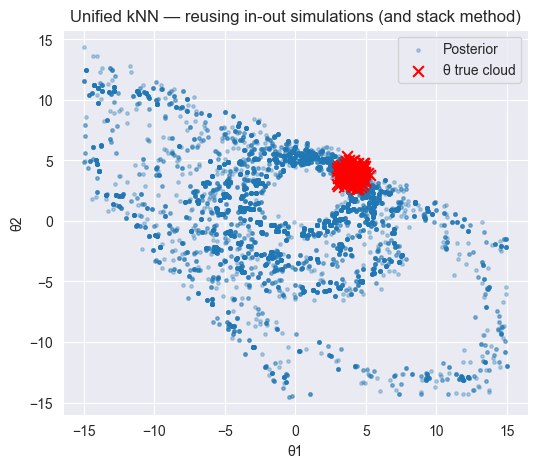

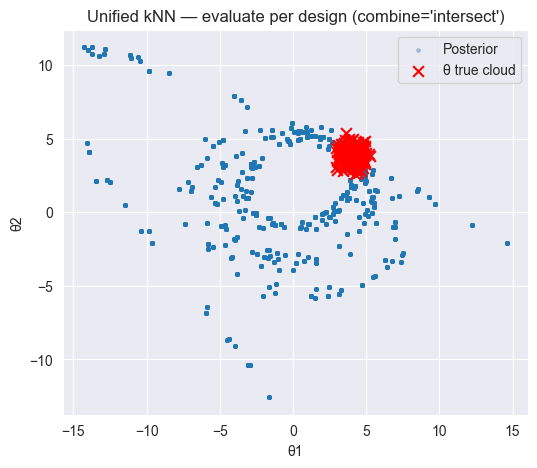

In [6]:

N_SIM = 500_000
knn = 10
resample_n = 10000

theta_sim_pool = theta_sampler(N_SIM)
xi_sim_pool = rng.uniform(-4, 4, size=(N_SIM, 1))
y_sim_pool = paraboloid_model(theta_sim_pool, xi_sim_pool)

simulated_data = {"y": y_sim_pool, "theta": theta_sim_pool, "xi": xi_sim_pool}
# 'prep model
calib_comb = KNNCalibrator(knn=knn, evaluate_model=False, a_tol=0.05)
calib_comb.setup(simulated_data=simulated_data, xi_list=xi_list_c3)


# 'vote' = stack
post_reuse = calib_comb.calibrate(observations_c3, combine="stack", resample_n=resample_n)
theta_post_reuse = post_reuse["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_reuse, truth=theta_true_cloud,
             title="Unified kNN — reusing in-out simulations (and stack method)")
plt.show()


# 'vote' = intersect
post_eval_vote = calib_comb.calibrate(observations_c3, combine="intersect", resample_n=resample_n)
theta_post_vote = post_eval_vote["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, theta_post_vote, truth=theta_true_cloud,
             title="Unified kNN — evaluate per design (combine='intersect')")
plt.show()


C:\Users\roberto.rocchetta\Documents\GitHub\KNNcalibration_experimental\plotting.py:18: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, colors='k', linewidths=0.5, label = 'kde')


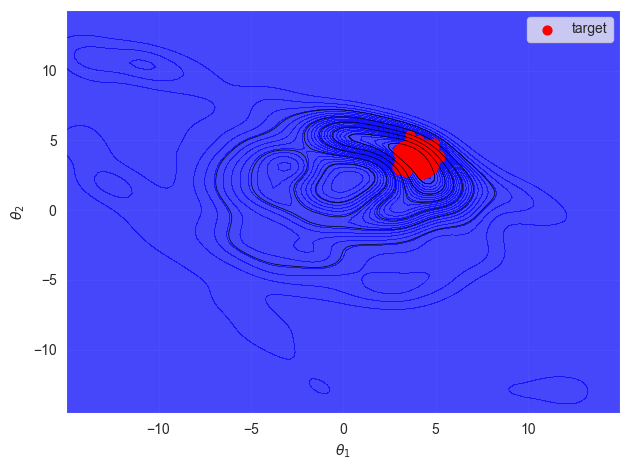

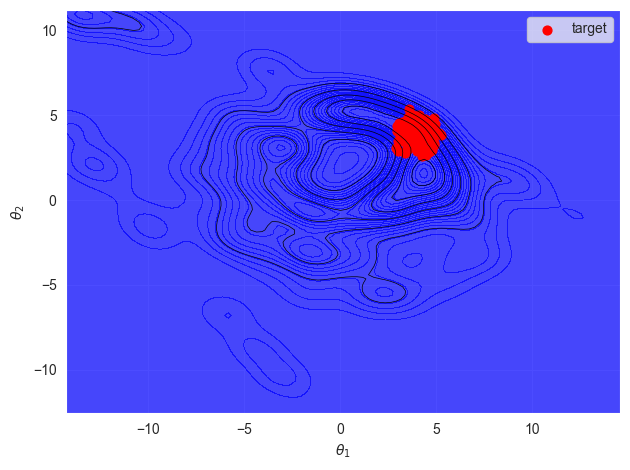

In [10]:
from plotting import plot_kde_2d , weighted_mixture_kde

# --- Plot individual KDEs ---
plot_kde_2d(theta_post_reuse, true_theta=theta_true_cloud)
plot_kde_2d(theta_post_vote, true_theta=theta_true_cloud)


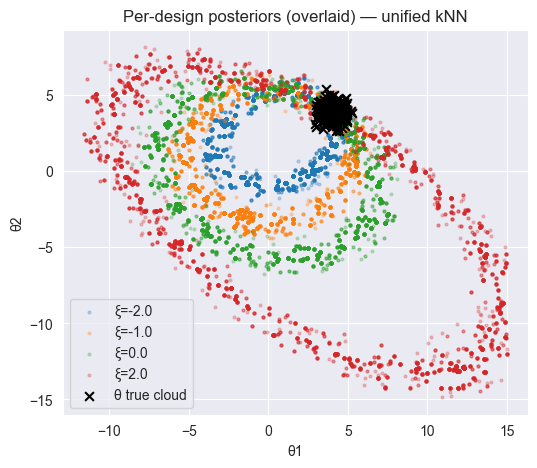

In [7]:
fig, ax = plt.subplots(figsize=(6,5))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for c, xi in zip(colors, xi_list_c3):
    post_xi = calib_comb.calibrate([(next(y for (y,x) in observations_c3 if np.isclose(x, xi)), xi)],
                                   combine="stack", resample_n=5000)
    th_xi = post_xi["theta"]
    ax.scatter(th_xi[:,0], th_xi[:,1], s=4, alpha=0.25, label=f"ξ={xi}", c=c)
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1], c="k", marker="x", s=40, label="θ true cloud")
ax.set_title("Per-design posteriors (overlaid) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.grid(True); ax.legend()
plt.show()

In [8]:
from scipy.stats import gaussian_kde
posters = []
for xi in xi_list_c3:
    y_i = next(y for (y,x) in observations_c3 if np.isclose(x, xi))
    post_i = calib_comb.calibrate([(y_i, xi)], combine="stack", resample_n=1000)
    posters.append((xi, post_i["theta"]))

stack_all = np.vstack([th for _, th in posters] + [theta_true_cloud])
x_min, x_max = np.percentile(stack_all[:,0], [1, 99])
y_min, y_max = np.percentile(stack_all[:,1], [1, 99])
nx, ny = 200, 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
grid = np.vstack([xx.ravel(), yy.ravel()])

zz = np.zeros((ny, nx))
for (c, (xi, th_xi)) in zip(colors, posters):
    kde = gaussian_kde(th_xi.T, bw_method='scott') # KDE on the posterior samples of this design
    zz_grid = kde(grid).reshape(ny, nx)
    zz += np.log(zz_grid)

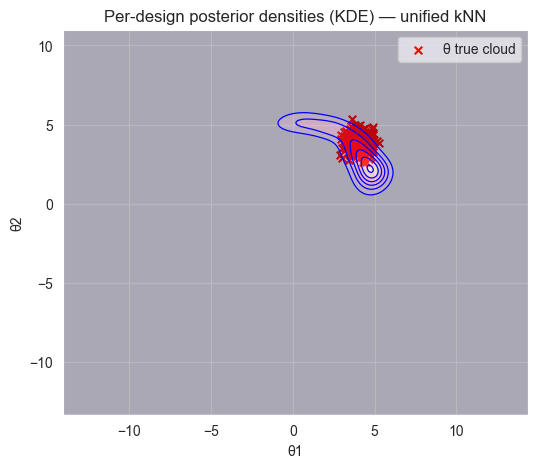

In [9]:
fig, ax = plt.subplots(figsize=(6,5))
zz_lik = np.exp(zz)# filled contours + a thin outline
ax.scatter(theta_true_cloud[:,0], theta_true_cloud[:,1],
           c="r", marker="x", s=30, label="θ true cloud")  # true cloud on top

csf = ax.contourf(xx, yy, zz_lik, levels=8, alpha=0.3, antialiased=True)
ax.contour(xx, yy, zz_lik, levels=8, colors='b', linewidths=0.9)

ax.set_title("Per-design posterior densities (KDE) — unified kNN")
ax.set_xlabel("θ1"); ax.set_ylabel("θ2"); ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.grid(True); ax.legend()
plt.show()
